In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

* **dteday** : time range,January 1 2011 to December 31 2012. 
* **season** : categorical feature, which season the rental happened
* **holiday** : categorical feature, whether that day is a holiday.
* **casual,registered, cnt** : The number of riders is split between casual and registered, summed up in the `cnt` column. 
* **weathersit, temp, atemp, hum, windspeed** : weather features, including temperature, humidity, windspeed



Below is a plot showing the number of bike riders over the first 10 days or so in the data set. _(Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.)_  Hourly rentals can be seen from the graph

The weekends _(2011-01-01 to 2011-01-02 and 2011-01-07 to 2011-01-09)_ have lower over all ridership and there are spikes when people are biking to and from work during the week. 

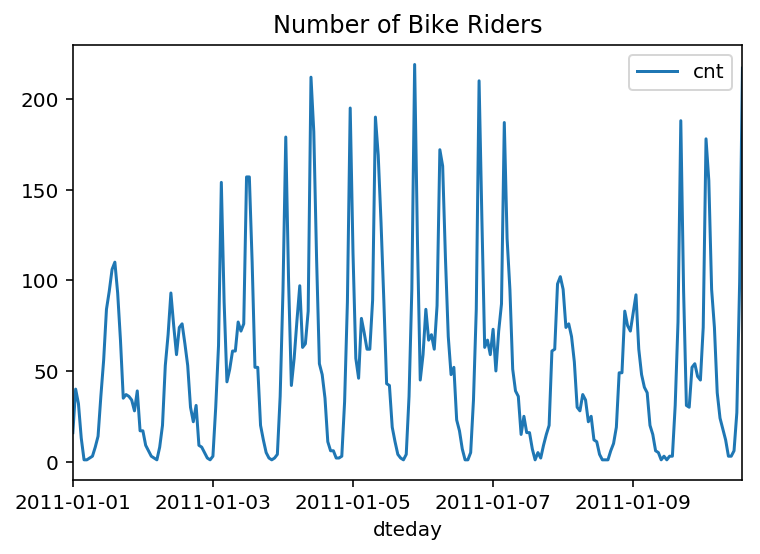

<Figure size 720x576 with 0 Axes>

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')
plt.title('Number of Bike Riders')
plt.figure(figsize=(10,8))
plt.show()

### Dummy variables

* Here we have some categorical variables like season, weather, month. 
* Need to make binary dummy variables. 
* Implement with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables

* Standardize each of the continuous variables. 
* That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

* The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

* Save the data for the last approximately 21 days to use as a test set after trained the network. 


In [7]:
# Save data for approximately the last 21 days 
# testing
test_data = data[-21*24:]

# training
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

* split the data into two sets, one for training and one for validating as the network is being trained. 
* Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [9]:
# Check the training set feature shape
train_features.shape

(15435, 56)

 # Building Neural Network

<img src="assets/neural_network.png" width=300px>

* The network has two layers, a hidden layer and an output layer. 
* The **hidden layer** will use the sigmoid function for activations. 
* The **output layer** has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. 
  

In [10]:
#############
# In the Neural_Network.py file, import Neural Network Architecture
#############

from Neural_Network import NeuralNetwork

In [11]:
# Defiine Mean Square Error Function

def MSE(y, Y):
    '''Mean Square Error
    
    y: array of real target
    Y: array of predicted target
    '''
    return np.mean((y-Y)**2)

## Training the network
### hyper-parameter tuning

* #### Number of iterations
     * The more iterations used, the better the model will fit the data. 
     * However, this process can have sharply diminishing returns and can waste computational resources if use too many iterations.  
     * The ideal number of iterations would be a level that stops shortly after the validation loss is no longer decreasing.

* #### Learning rate
    * This scales the size of weight updates. 
    * If this is too big, the weights tend to explode and the network fails to fit the data. 
    * Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

* #### Number of hidden nodes
    * In a model where all the weights are optimized, the more hidden nodes you have, the more accurate the predictions of the model will be.  (A fully optimized model could have weights of zero, after all.) 
    * However, the more hidden nodes the model has, the harder it will be to optimize the weights of the model, and the more likely it will be that suboptimal weights will lead to overfitting. With overfitting, the model will memorize the training data instead of learning the true pattern, and won't generalize well to unseen data.  

In [21]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

from Neural_Network import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['cnt']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.2% ... Training loss: 32.89 ... Validation loss: 34.69

C:\Users\mengq\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


Progress: 100.0% ... Training loss: 0.076 ... Validation loss: 0.184

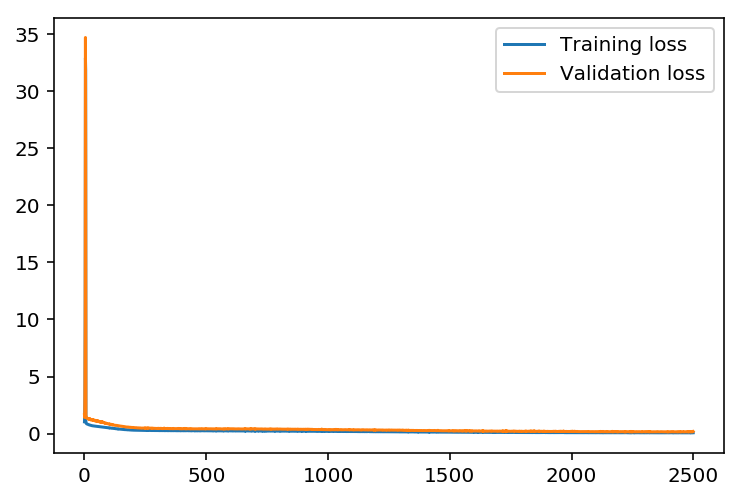

In [22]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

## Predictions
#### Check out the prediction by graph

From the graph, we can see that the model predicts well from Dec.11 to Dec.20, but fails around Christmas, that might be caused by the hoilday that affect the results.


C:\Users\mengq\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


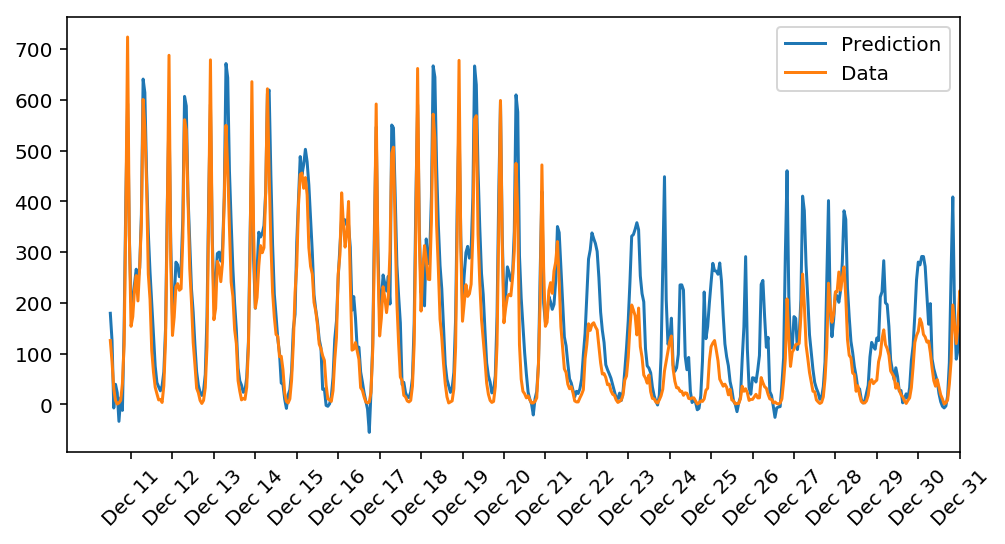

In [23]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)